In [1]:
using LinearAlgebra, Random,BenchmarkTools

In [2]:
using JuMP, SCS, SparseArrays

In [3]:
using Plots

In [4]:
begin
    n=200
    k=7 #Int(ceil(sqrt(2*n)+1))
    A = Symmetric(round.(rand(n,n))) 
    C= (A - I + abs.(A-I))/2 
   # C = rand(n,n)
end

200×200 Matrix{Float64}:
 0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  0.0  1.0
 1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0     0.0  1.0  0.0  1.0  0.0  0.0  1.0
 1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0     0.0  0.0  1.0  0.0  1.0  0.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0     0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  …  0.0  1.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0     1.0  1.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0     1.0  1.0  0.0  1.0  0.0  1.0  1.0
 0.0  0.0  1.0  0.0  1.0  1.0  1.0  1.0     0.0  1.0  0.0  1.0  1.0  0.0  1.0
 1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0     0.0  1.0  1.0  1.0  1.0  0.0  1.0
 1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  …  1.0  0.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0

In [24]:
function randserial(n,k,C,ϵ=1e-7)
    Costs = []
    V=rand(k,n)
    counter=0
    Vs = []

    for i in 1:n
        V[:,i] = test3(i,V,C)
    end
    
    for j=1:n*k*2*4
       # Threads.@threads for _=1:8
            i=rand(1:n)
            V[:,i] = test3(i,V,C)
      #  end
        push!(Costs,tr(V* C* V'))
        push!(Vs, V'*V)
    end
    Vs
    Costs
    print(Costs[end])
    plot(Costs)
end

randserial (generic function with 2 methods)

In [27]:
function randparallel(n,k,C,ϵ=1e-7)
    Costs = []
    V=rand(k,n)
    counter=0
    Vs = []

    for i in 1:n
        V[:,i] = test3(i,V,C)
    end
    
    Threads.@threads for j=1: Int(n*k*2*4)
      #  Threads.@threads for _=1:100
            i=rand(1:n)
            V[:,i] = test3(i,V,C)
     #   end
        push!(Costs,tr(V* C* V'))
        push!(Vs, V'*V)
    end
    Vs
    Costs
    print(Costs[end])
    try
        plot(Costs)
    finally
    end
end

randparallel (generic function with 2 methods)

In [7]:
randparallel(n,k,C)

LoadError: UndefVarError: test3 not defined

In [8]:
begin
	function test3(i,V,C)
		ans3=-(V*C[i,:])
		ans3/=norm(ans3)
		return ans3
	end
end

test3 (generic function with 1 method)

In [9]:
Threads.nthreads()

4

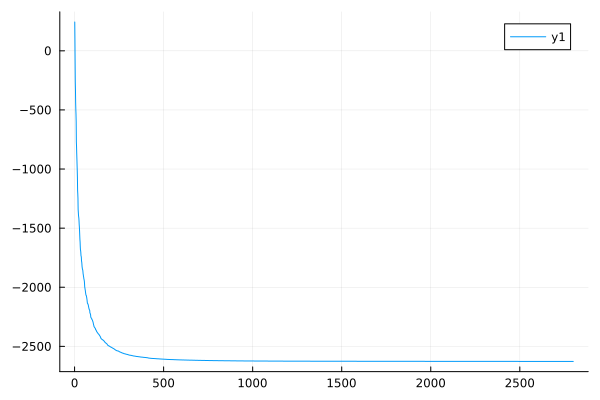

In [10]:
    Costs = []
    V=rand(k,n)
    counter=0
    Vs = []

    for i in 1:n
        V[:,i] = test3(i,V,C)
    end
    
    for j=1:n*k*2
        Threads.@threads for _=1:8
            i=rand(1:n)
            V[:,i] = test3(i,V,C)
        end
        push!(Costs,tr(V* C* V'))
        push!(Vs, V'*V)
    end
    Vs
    Costs
    plot(Costs)


In [11]:
Costs[end]

-2627.270383257388

In [12]:
function JuMPspeed()
	model = Model(SCS.Optimizer)
	@variable(model, X[1:n,1:n], PSD)
	for i in 1:n
	@constraint(model, X[i,i] == 1)
	end
	@constraint(model, X ≥ 0, PSDCone())
	@objective(model, Min, sum(C.*X))
	optimize!(model)
	return value(X)
end
trueSol = JuMPspeed()

------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 20100, constraints m: 40400
cones: 	  z: primal zero / dual free vars: 200
	  s: psd vars: 40200, ssize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 40400, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 4.72e+01  6.96e+00  2.81e+05 -1.40e+05  1.00e-01  9.90e-02 
   225| 2.73e-05  3.74e-06  7.43e-06 -2.63e+03  3.97e-01  1.45e+01 
-----------------

200×200 Symmetric{Float64, Matrix{Float64}}:
  1.0         -0.0237822   0.0977667   …   0.218751   0.688464    -0.888841
 -0.0237822    1.0         0.240473       -0.356066   0.0895995    0.0677637
  0.0977667    0.240473    1.0            -0.388755   0.299941     0.025511
 -0.083192     0.589771    0.00838778     -0.722553   0.436555     0.136875
  0.681328     0.395143    0.15066         0.05503    0.741922    -0.520072
  0.216766     0.303199    0.806097    …  -0.746164   0.655796    -0.11302
 -0.550645     0.680511    0.240858       -0.29762   -0.183168     0.667484
 -0.22208     -0.0441003   0.509059        0.406081  -0.485127     0.209094
  0.838138    -0.0488585  -0.37671         0.365964   0.416338    -0.906728
 -0.43243      0.343997    0.664853       -0.844458   0.128618     0.509644
 -0.357489    -0.24601    -0.402137    …   0.63955   -0.557183     0.14823
 -0.426466     0.434304    0.0424694      -0.783869   0.0365529    0.179786
  0.913364     0.182865   -0.0887043       0

In [13]:
sum(trueSol.*C)

-2627.730969612626

In [14]:
sum(Vs[33].*C)

-1684.2190536544185

In [15]:
Vs[end]

200×200 Matrix{Float64}:
  1.0         -0.0706982   0.0924986  …   0.256362    0.717906   -0.893806
 -0.0706982    1.0         0.21007       -0.353923    0.127253    0.12518
  0.0924986    0.21007     1.0           -0.374883    0.297562    0.0249605
 -0.0747468    0.621336    0.0282662     -0.769955    0.448684    0.134444
  0.712768     0.417215    0.16323        0.0270858   0.737999   -0.568734
  0.212398     0.271513    0.821207   …  -0.741568    0.656662   -0.0992608
 -0.535503     0.739345    0.238092      -0.320646   -0.200338    0.64565
 -0.226337    -0.020547    0.507259       0.390424   -0.5036      0.220431
  0.839637    -0.121153   -0.385957       0.426017    0.473064   -0.910964
 -0.440492     0.388073    0.641042      -0.858915    0.110052    0.529094
 -0.357422    -0.228978   -0.374446   …   0.629587   -0.577326    0.139668
 -0.455964     0.469952    0.0194873     -0.752321    0.0561595   0.215748
  0.902735     0.0954628  -0.0849792      0.20099     0.757472   -0.84062
 

In [16]:
eigen(trueSol)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
200-element Vector{Float64}:
 -6.098937208707178e-5
 -1.4963638864287826e-5
 -1.4541077458158162e-5
 -1.3353375579668398e-5
 -1.1793226467946501e-5
 -1.1323407902356755e-5
 -1.0800215430761824e-5
 -9.256921650764456e-6
 -8.715695508460016e-6
 -8.39404038145606e-6
 -7.850029225535438e-6
 -7.639317371334866e-6
 -7.247623064312438e-6
  ⋮
  2.4381621837157757e-5
  2.6571404746316744e-5
  2.6897085916498617e-5
  2.964450648991189e-5
  0.8313621384487515
  3.4433782083285207
 10.821423537349096
 19.95770434440207
 24.02838631009698
 34.30365247230694
 49.448138512482764
 57.164892797097835
vectors:
200×200 Matrix{Float64}:
 -0.0752173  -0.0223636     0.015032     …  -0.0931444   -0.0809012
 -0.0695594   0.0360234     0.0112208        0.0733333   -0.0538933
 -0.062208   -0.00644671   -0.0283701        0.0420759    0.0117953
 -0.0640448  -0.00538038    0.0119658        0.096553    -0.0914442
 -0.0735229   0.0387867    -0.0351974

In [17]:
@time JuMPspeed();

 14.063283 seconds (1.23 M allocations: 95.159 MiB, 0.98% gc time)
------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 20100, constraints m: 40400
cones: 	  z: primal zero / dual free vars: 200
	  s: psd vars: 40200, ssize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 40400, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 4.72e+01  6.96e+00  2.81e+05 -1.40e+05  1.00e-01  9.52e-02 
   225| 2.73e-05  

In [18]:
@btime randserial(n,k,C)

  2.088 s (101619 allocations: 3.48 GiB)


11200-element Vector{Any}:
   356.7483008912988
   356.38123266372645
   283.8271616133268
   283.6480411872475
   280.9869574009061
   263.69282740864855
   205.85762872591562
   176.91049396588224
    78.59237320305903
    50.98919431026642
    50.77648839615814
    50.683373995692854
    50.52415299859453
     ⋮
 -2626.27437150072
 -2626.274531407044
 -2626.2746565331418
 -2626.274892968693
 -2626.274943158351
 -2626.2750632128373
 -2626.2752543392876
 -2626.275321524989
 -2626.275712928675
 -2626.2759255117226
 -2626.276153632328
 -2626.2763498731065

In [19]:
#@btime parallelSerial(n,k,C)

-2627.025814105015  9.229669 seconds (145.83 k allocations: 3.486 GiB, 33.10% gc time)


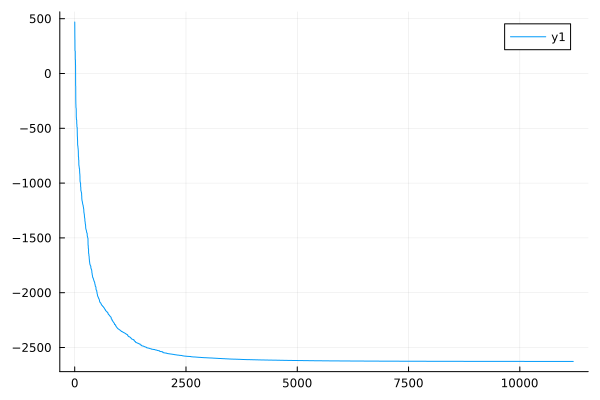

In [30]:
@time randserial(n,k,C)

-2626.9827341111923  3.563828 seconds (145.85 k allocations: 3.486 GiB)


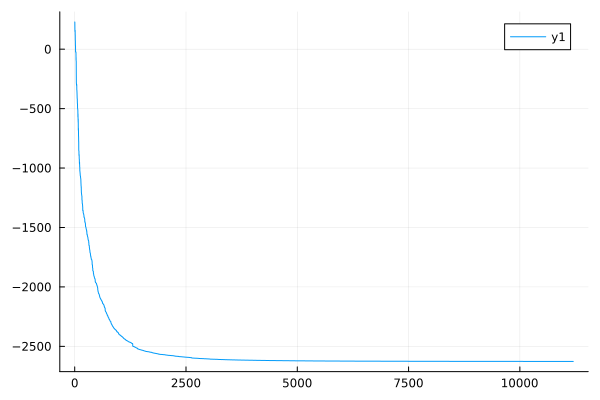

In [29]:
@time randparallel(n,k,C)

In [22]:
9.8/6.

1.6333333333333335